In [38]:
# Import our dependencies
!pip install --upgrade sqlalchemy==1.4.39
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import config

In [18]:
# Connection details for AWS RDS PostgreSQL database
endpoint = config.endpoint
db_name = config.db_name
username = config.username
password = config.password

# Create connection string
connection_string = f'postgresql://{username}:{password}@{endpoint}/{db_name}'

# Create engine
engine = create_engine(connection_string)

# SQL query to select data from a table
query = "SELECT * FROM all_categories"

# Read data from the database into a Pandas DataFrame
df = pd.read_sql(query, engine)

# Display the DataFrame
df.tail()

,stars,reviews,price,categoryname,isbestseller,boughtinlastmonth,titlelength
1988011,0.0,0,52.99,Play Sets Playground Equipment,0,0,190
1988012,0.0,0,15.99,Play Sets Playground Equipment,0,0,106
1988013,0.0,0,15.29,Play Sets Playground Equipment,0,0,84
1988014,0.0,0,21.09,Play Sets Playground Equipment,0,0,150
1988015,0.0,0,21.99,Play Sets Playground Equipment,0,0,142


In [20]:
# Rename columns to camel case as was in original CSV
df.rename(columns={'categoryname': 'categoryName', 'isbestseller': 'isBestSeller', 'boughtinlastmonth': 'boughtInLastMonth', 'titlelength': 'titleLength'}, inplace=True)
df.columns

Index(['stars', 'reviews', 'price', 'categoryName', 'isBestSeller',
       'boughtInLastMonth', 'titleLength'],
      dtype='object')

In [21]:
# Verify Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988016 entries, 0 to 1988015
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   stars              float64
 1   reviews            int64  
 2   price              float64
 3   categoryName       object 
 4   isBestSeller       int64  
 5   boughtInLastMonth  int64  
 6   titleLength        int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 106.2+ MB


In [22]:
# Determine the number of unique values in each column.
df.nunique()

stars                   42
reviews              20997
price                81372
categoryName           266
isBestSeller             2
boughtInLastMonth       22
titleLength            476
dtype: int64

In [23]:
# Determine the number of unique values in categoryName column.
df['categoryName'].value_counts()

Baby                            24077
Luggage  Travel Gear            22449
Handmade Home Décor             19143
Handmade Kitchen  Dining        19074
Handmade Jewellery              18545
                                ...  
Kids' Ball Pits  Accessories      587
Blu-ray Players  Recorders        467
Smart Home                        434
STEM                              210
International Food Market         152
Name: categoryName, Length: 266, dtype: int64

In [24]:
# Choose a cutoff value of 9000 and create a list of categoryName to be replaced to others
remained_categories = df['categoryName'].value_counts().index[df['categoryName'].value_counts() < 9000]

# Replace in dataframe
for category in remained_categories:
    df['categoryName'] = df['categoryName'].replace(category,"Other")

# Drop rows where categoryName is other
df = df[df['categoryName'] != 'Other']


In [25]:
# Determine the number of unique values in categoryName column.
df['categoryName'].nunique()

53

In [26]:
# Verify rows has been dropped
df['categoryName'].value_counts()

Baby                                     24077
Luggage  Travel Gear                     22449
Handmade Home Décor                      19143
Handmade Kitchen  Dining                 19074
Handmade Jewellery                       18545
Beauty                                   18320
Men's Jewelry                            17969
Women's Watches                          17386
Boys                                     17233
Electronics                              16393
Men's Watches                            16385
Uniforms, Work  Safety                   16150
Men's Shoes                              16049
Women's Shoes                            15964
Beauty Tools  Accessories                15868
Men                                      15768
Shaving  Hair Removal Products           15702
Grocery                                  15601
Women                                    15576
Perfume  Cologne                         15552
Salon  Spa Equipment                     15417
Bath  Body   

In [30]:
# Mismatched classifications
df['isBestSeller'].value_counts()

0    716645
1      3211
Name: isBestSeller, dtype: int64

In [29]:
# Convert categorical data to numeric with `pd.get_dummies`
dummy_df = pd.get_dummies(df)
dummy_df.head()

,stars,reviews,price,isBestSeller,boughtInLastMonth,titleLength,categoryName_Arts Crafts Supplies,categoryName_Automotive Replacement Parts,categoryName_Automotive Tires Wheels,categoryName_Automotive Tools Equipment,...,categoryName_Skin Care Products,categoryName_Snow Ice Sports,"categoryName_Uniforms, Work Safety",categoryName_Women,categoryName_Women's Accessories,categoryName_Women's Clothing,categoryName_Women's Handbags,categoryName_Women's Jewelry,categoryName_Women's Shoes,categoryName_Women's Watches
3355,4.5,43171,29.99,1,0,254,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3356,4.7,215,5.98,1,900,132,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3357,3.9,1006,14.22,1,1000,55,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3358,4.3,17381,12.99,1,900,195,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3359,5.0,1,21.69,1,200,189,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Split our preprocessed data into our features and target arrays
y = dummy_df["isBestSeller"].values
X = dummy_df.drop(["isBestSeller", "boughtInLastMonth"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [34]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
no_input_features = len(X_train[0])
hidden_nodes_layer1 = 15

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=no_input_features, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 15)                870       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 886 (3.46 KB)
Trainable params: 886 (3.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=75)

Epoch 1/75
16872/16872 [==============================] - 30s 2ms/step - loss: 0.0290 - accuracy: 0.9938
Epoch 2/75
16872/16872 [==============================] - 29s 2ms/step - loss: 0.0233 - accuracy: 0.9955
Epoch 3/75
16872/16872 [==============================] - 29s 2ms/step - loss: 0.0231 - accuracy: 0.9955
Epoch 4/75
16872/16872 [==============================] - 29s 2ms/step - loss: 0.0229 - accuracy: 0.9955
Epoch 5/75
16872/16872 [==============================] - 32s 2ms/step - loss: 0.0229 - accuracy: 0.9955
Epoch 6/75
16872/16872 [==============================] - 30s 2ms/step - loss: 0.0228 - accuracy: 0.9955
Epoch 7/75
16872/16872 [==============================] - 29s 2ms/step - loss: 0.0227 - accuracy: 0.9955
Epoch 8/75
16872/16872 [==============================] - 31s 2ms/step - loss: 0.0227 - accuracy: 0.9956
Epoch 9/75
16872/16872 [==============================] - 30s 2ms/step - loss: 0.0226 - accuracy: 0.9956
Epoch 10/75
16872/16872 [==============================

In [ ]:
# Evaluate the ORIGINAL model (live)
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

5624/5624 - 7s - loss: 0.0225 - accuracy: 0.9955 - 7s/epoch - 1ms/step
Loss: 0.022487729787826538, Accuracy: 0.9955102205276489


In [ ]:
# Save ORIGINAL model
nn.save('Original_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
# load the non balanced model
loaded_model = load_model("/Original_model.h5")

In [36]:
# Evaluate the ORIGINAL model (loaded)
model_loss, model_accuracy = loaded_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

5624/5624 - 8s - loss: 0.0226 - accuracy: 0.9955 - 8s/epoch - 1ms/step
Loss: 0.02255859412252903, Accuracy: 0.9954879879951477


In [42]:
# Accuracy and Recall for ORIGINAL model (loaded)

# Make predictions on the test data
y_pred = loaded_model.predict(X_test_scaled)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5)

# Accuracy calculation
accuracy = accuracy_score(y_test, y_pred_binary)

# Recall calculation
recall = recall_score(y_test, y_pred_binary)

# Print accuracy and recall
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")

5624/5624 [==============================] - 8s 2ms/step
Accuracy: 0.9954879864861861
Recall: 0.0


In [43]:
# Balancing target values
ros = RandomOverSampler(random_state=1)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

In [44]:
# Confirm the resampling worked
y_train_resampled_series = pd.Series(y_train_resampled)
y_train_resampled_series.value_counts()

0    537493
1    537493
dtype: int64

In [47]:
# Define the re sampled model
no_input_features = len(X_train_resampled[0])
hidden_nodes_layer1 = 15

nn_resampled = tf.keras.models.Sequential()

# First hidden layer
nn_resampled.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=no_input_features, activation="relu"))

# Output layer
nn_resampled.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_resampled.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 15)                870       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 886 (3.46 KB)
Trainable params: 886 (3.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# Compile the resampled model
nn_resampled.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [49]:
# Train the resampled model
fit_model_resampled = nn_resampled.fit(X_train_resampled, y_train_resampled, epochs=75)

Epoch 1/75
33594/33594 [==============================] - 69s 2ms/step - loss: 0.3663 - accuracy: 0.8329
Epoch 2/75
33594/33594 [==============================] - 67s 2ms/step - loss: 0.3466 - accuracy: 0.8457
Epoch 3/75
33594/33594 [==============================] - 65s 2ms/step - loss: 0.3418 - accuracy: 0.8485
Epoch 4/75
33594/33594 [==============================] - 63s 2ms/step - loss: 0.3395 - accuracy: 0.8498
Epoch 5/75
33594/33594 [==============================] - 63s 2ms/step - loss: 0.3378 - accuracy: 0.8512
Epoch 6/75
33594/33594 [==============================] - 64s 2ms/step - loss: 0.3367 - accuracy: 0.8519
Epoch 7/75
33594/33594 [==============================] - 66s 2ms/step - loss: 0.3356 - accuracy: 0.8522
Epoch 8/75
33594/33594 [==============================] - 64s 2ms/step - loss: 0.3349 - accuracy: 0.8523
Epoch 9/75
33594/33594 [==============================] - 63s 2ms/step - loss: 0.3342 - accuracy: 0.8526
Epoch 10/75
33594/33594 [==============================

In [51]:
# Save resampled model
nn_resampled.save('Resampled_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
# Evaluate the RESAMPLED model (live)
model_loss_resampled, model_accuracy_resampled = nn_resampled.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss_resampled}, Accuracy: {model_accuracy_resampled}")

5624/5624 - 7s - loss: 0.3784 - accuracy: 0.8069 - 7s/epoch - 1ms/step
Loss: 0.37840181589126587, Accuracy: 0.8068835735321045


In [52]:
# Load resampled model
loaded_model_resampled = load_model("/content/Resampled_model.h5")

In [53]:
# Evaluate the RESAMPLED model (loaded)
model_loss_resampled, model_accuracy_resampled = loaded_model_resampled.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss_resampled}, Accuracy: {model_accuracy_resampled}")

5624/5624 - 10s - loss: 0.3784 - accuracy: 0.8069 - 10s/epoch - 2ms/step
Loss: 0.37840181589126587, Accuracy: 0.8068835735321045


In [55]:
# Accuracy and Recall for RESAMPLED model (loaded)

# Make predictions on the test data
y_pred = loaded_model_resampled.predict(X_test_scaled)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5)

# Accuracy calculation
accuracy = accuracy_score(y_test, y_pred_binary)

# Recall calculation
recall = recall_score(y_test, y_pred_binary)

# Print accuracy and recall
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")

5624/5624 [==============================] - 8s 1ms/step
Accuracy: 0.8068835989420107
Recall: 0.853448275862069


In [ ]:
# Assuming the score are satisfactory --> MOVE ON TO FEATURE ANALYSIS

In [ ]:
# Feature importance Analysis -------------------------------------------------------------------------------------

In [56]:
X_train_resampled_tensor = tf.convert_to_tensor(X_train_resampled, dtype=tf.float32)


predictions = nn_resampled.predict(X_train_resampled_tensor)

# Compute gradients of predictions with respect to X_train_resampled_tensor
with tf.GradientTape() as tape:
    tape.watch(X_train_resampled_tensor)
    predictions = nn_resampled(X_train_resampled_tensor)

# Compute gradients of predictions with respect to X_train_resampled_tensor
gradients = tape.gradient(predictions, X_train_resampled_tensor)

# Compute feature importance by taking the absolute mean of gradients
feature_importance = tf.reduce_mean(tf.abs(gradients), axis=0)

33594/33594 [==============================] - 51s 2ms/step


In [57]:
feature_importance

<tf.Tensor: shape=(57,), dtype=float32, numpy=
array([0.18020764, 1.7117972 , 0.37728062, 0.08130442, 0.25890526,
       0.23656878, 0.28070894, 0.2599115 , 0.29279748, 0.33340117,
       0.3457197 , 0.46749058, 0.27638546, 0.34816933, 0.26910904,
       0.30173367, 0.31603104, 0.30348766, 0.3348553 , 0.37036437,
       0.3414622 , 0.28797033, 0.4092058 , 0.35349035, 0.2655112 ,
       0.23875278, 0.38917923, 0.30067956, 0.30953255, 0.3693135 ,
       0.29478312, 0.30835453, 0.4245558 , 0.3600292 , 0.38476524,
       0.292919  , 0.3370138 , 0.30201644, 0.26380697, 0.23007546,
       0.3275945 , 0.23406142, 0.25275818, 0.2747866 , 0.32336637,
       0.33658504, 0.3274252 , 0.30324808, 0.2628403 , 0.41544342,
       0.3284895 , 0.3415567 , 0.2633195 , 0.33929914, 0.34137022,
       0.36054236, 0.36617386], dtype=float32)>

In [58]:
features_cols = dummy_df.drop(['isBestSeller', 'boughtInLastMonth'], axis=1).columns
features_cols

Index(['stars', 'reviews', 'price', 'titleLength',
       'categoryName_Arts  Crafts Supplies',
       'categoryName_Automotive Replacement Parts',
       'categoryName_Automotive Tires  Wheels',
       'categoryName_Automotive Tools  Equipment', 'categoryName_Baby',
       'categoryName_Bath  Body', 'categoryName_Beauty',
       'categoryName_Beauty Tools  Accessories',
       'categoryName_Boating  Watersports', 'categoryName_Boys',
       'categoryName_Cycling Equipment', 'categoryName_DVD Players  Recorders',
       'categoryName_Electronics', 'categoryName_Girls',
       'categoryName_Grocery', 'categoryName_Hair Care',
       'categoryName_Handmade Artwork',
       'categoryName_Handmade Clothing, Shoes  Accessories',
       'categoryName_Handmade Home Décor', 'categoryName_Handmade Jewellery',
       'categoryName_Handmade Kitchen  Dining',
       'categoryName_Hunting  Fishing', 'categoryName_Luggage  Travel Gear',
       'categoryName_Mailboxes  Accessories', 'categoryName_Mak

In [61]:
feature_importance_df = pd.DataFrame({
    'Feature': features_cols,
    'Importance': feature_importance.numpy()
})

In [64]:
# Using this to rank the features and decide which one to do the interaction terms with
feature_importance_df[feature_importance_df['Feature'].isin(['reviews', 'price', 'stars', 'titleLength'])].sort_values('Importance', ascending=False)

,Feature,Importance
1,reviews,1.711797
2,price,0.377281
0,stars,0.180208
3,titleLength,0.081304


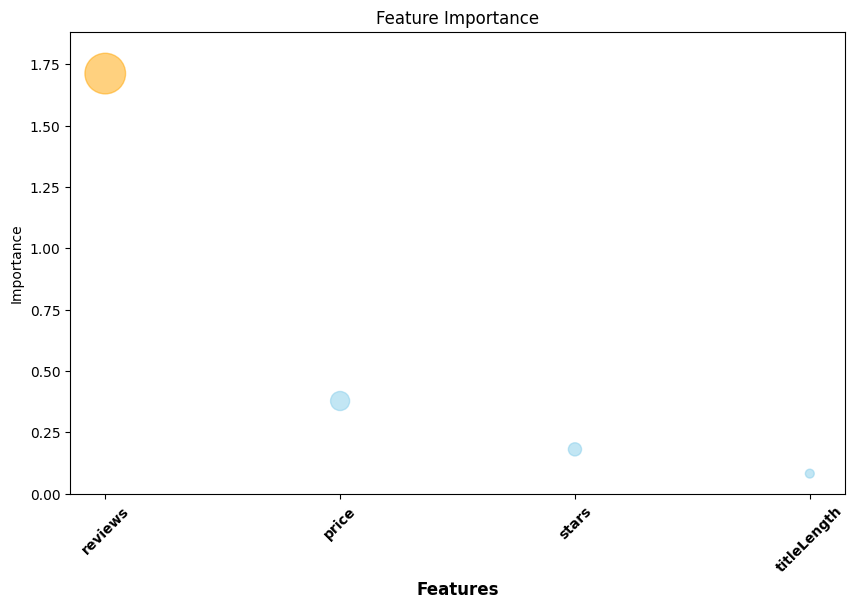

In [69]:
# Feature importance visualization (PRE INTERACTION TERMS)
# Data
features = ['reviews', 'price', 'stars', 'titleLength']
importance = [1.711797, 0.377281, 0.180208, 0.081304]

# Define colors for each feature
colors = ['orange' if feat == 'reviews' else 'skyblue' for feat in features]

# Calculate circle sizes based on importance values
sizes = [imp * 500 for imp in importance]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(features, importance, s=sizes, color=colors, alpha=0.5)
plt.title('Feature Importance')
plt.xlabel('Features', fontsize=12, fontweight='bold')
plt.ylabel('Importance')
plt.xticks(features, fontsize=10, fontweight='bold')
plt.xticks(rotation=45)
plt.ylim(0, max(importance) * 1.1)
plt.grid(False)

# Show plot
plt.show()

In [ ]:
# Interaction Terms introduced --------------------------------------------------------------------

In [70]:
dummy_df.head()

,stars,reviews,price,isBestSeller,boughtInLastMonth,titleLength,categoryName_Arts Crafts Supplies,categoryName_Automotive Replacement Parts,categoryName_Automotive Tires Wheels,categoryName_Automotive Tools Equipment,...,categoryName_Skin Care Products,categoryName_Snow Ice Sports,"categoryName_Uniforms, Work Safety",categoryName_Women,categoryName_Women's Accessories,categoryName_Women's Clothing,categoryName_Women's Handbags,categoryName_Women's Jewelry,categoryName_Women's Shoes,categoryName_Women's Watches
3355,4.5,43171,29.99,1,0,254,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3356,4.7,215,5.98,1,900,132,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3357,3.9,1006,14.22,1,1000,55,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3358,4.3,17381,12.99,1,900,195,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3359,5.0,1,21.69,1,200,189,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# Calculate interaction terms between 'reviews' and encoded category features
interaction_terms = pd.DataFrame()
for column in dummy_df.columns:
    if column.startswith('categoryName_'):
        interaction_terms[column + '_reviews_interaction'] = dummy_df[column] * dummy_df['reviews']

# Concatenate the interaction terms with the original DataFrame
dummy_df_with_interaction = pd.concat([dummy_df, interaction_terms], axis=1)

In [72]:
dummy_df_with_interaction

,stars,reviews,price,isBestSeller,boughtInLastMonth,titleLength,categoryName_Arts Crafts Supplies,categoryName_Automotive Replacement Parts,categoryName_Automotive Tires Wheels,categoryName_Automotive Tools Equipment,...,categoryName_Skin Care Products_reviews_interaction,categoryName_Snow Ice Sports_reviews_interaction,"categoryName_Uniforms, Work Safety_reviews_interaction",categoryName_Women_reviews_interaction,categoryName_Women's Accessories_reviews_interaction,categoryName_Women's Clothing_reviews_interaction,categoryName_Women's Handbags_reviews_interaction,categoryName_Women's Jewelry_reviews_interaction,categoryName_Women's Shoes_reviews_interaction,categoryName_Women's Watches_reviews_interaction
3355,4.5,43171,29.99,1,0,254,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3356,4.7,215,5.98,1,900,132,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3357,3.9,1006,14.22,1,1000,55,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3358,4.3,17381,12.99,1,900,195,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3359,5.0,1,21.69,1,200,189,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924845,0.0,0,32.59,0,0,188,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1924846,0.0,0,15.21,0,0,188,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1924847,0.0,0,13.30,0,0,135,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1924848,0.0,0,11.87,0,0,136,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# Split our preprocessed data into our features and target arrays
y = dummy_df_with_interaction["isBestSeller"].values
X = dummy_df_with_interaction.drop(["isBestSeller", "boughtInLastMonth"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [74]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [75]:
# Balancing target values
ros = RandomOverSampler(random_state=1)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

In [76]:
# Confirm the resampling worked
y_train_resampled_series = pd.Series(y_train_resampled)
y_train_resampled_series.value_counts()

0    537493
1    537493
dtype: int64

In [ ]:
# Define the re sampled model
no_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 30
hidden_nodes_layer2 = 15

nn_resampled_interaction = tf.keras.models.Sequential()

# First hidden layer
nn_resampled_interaction.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=no_input_features, activation="relu"))

# Second hidden layer
nn_resampled_interaction.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn_resampled_interaction.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_resampled_interaction.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 30)                3330      
                                                                 
 dense_3 (Dense)             (None, 15)                465       
                                                                 
 dense_4 (Dense)             (None, 1)                 16        
                                                                 
Total params: 3811 (14.89 KB)
Trainable params: 3811 (14.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the resampled model
nn_resampled_interaction.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the resampled model
fit_model_resampled = nn_resampled_interaction.fit(X_train_resampled, y_train_resampled, epochs=100)

Epoch 1/100
33594/33594 [==============================] - 95s 3ms/step - loss: 0.3487 - accuracy: 0.8454
Epoch 2/100
33594/33594 [==============================] - 83s 2ms/step - loss: 0.3186 - accuracy: 0.8602
Epoch 3/100
33594/33594 [==============================] - 81s 2ms/step - loss: 0.3038 - accuracy: 0.8680
Epoch 4/100
33594/33594 [==============================] - 83s 2ms/step - loss: 0.2942 - accuracy: 0.8727
Epoch 5/100
33594/33594 [==============================] - 68s 2ms/step - loss: 0.2866 - accuracy: 0.8767
Epoch 6/100
33594/33594 [==============================] - 71s 2ms/step - loss: 0.2806 - accuracy: 0.8808
Epoch 7/100
33594/33594 [==============================] - 71s 2ms/step - loss: 0.2766 - accuracy: 0.8842
Epoch 8/100
33594/33594 [==============================] - 67s 2ms/step - loss: 0.2723 - accuracy: 0.8873
Epoch 9/100
33594/33594 [==============================] - 70s 2ms/step - loss: 0.2684 - accuracy: 0.8899
Epoch 10/100
33594/33594 [====================

In [ ]:
# Save - interaction terms model
nn_resampled_interaction.save('Interaction_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the interaction model (live)
model_loss_resampled, model_accuracy_resampled = nn_resampled_interaction.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss_resampled}, Accuracy: {model_accuracy_resampled}")

In [77]:
# Load interaction terms model
loaded_model_interaction = load_model('/Interaction_model.h5')

In [78]:
# Evaluate the interaction model
model_loss_resampled, model_accuracy_resampled = loaded_model_interaction.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss_resampled}, Accuracy: {model_accuracy_resampled}")

5624/5624 - 8s - loss: 0.4454 - accuracy: 0.8259 - 8s/epoch - 1ms/step
Loss: 0.44536516070365906, Accuracy: 0.8258596062660217


In [80]:
# Accuracy and Recall for INTERACTION model (loaded)

# Make predictions on the test data
y_pred = loaded_model_interaction.predict(X_test_scaled)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5)

# Accuracy calculation
accuracy = accuracy_score(y_test, y_pred_binary)

# Recall calculation
recall = recall_score(y_test, y_pred_binary)

# Print accuracy and recall
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")

5624/5624 [==============================] - 9s 2ms/step
Accuracy: 0.825859616367718
Recall: 0.8115763546798029


In [ ]:
# Accuracy and Recall for INTERACTION model (live)

# Make predictions on the test data
y_pred = nn_resampled_interaction.predict(X_test_scaled)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5)

# Accuracy calculation
accuracy = accuracy_score(y_test, y_pred_binary)

# Recall calculation
recall = recall_score(y_test, y_pred_binary)

# Print accuracy and recall
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")

In [ ]:
# Feature analysis for the interaction terms...

In [82]:
X_train_resampled_tensor = tf.convert_to_tensor(X_train_resampled, dtype=tf.float32)


predictions = loaded_model_interaction.predict(X_train_resampled_tensor)

# Compute gradients of predictions with respect to X_train_resampled_tensor
with tf.GradientTape() as tape:
    tape.watch(X_train_resampled_tensor)
    predictions = loaded_model_interaction(X_train_resampled_tensor)

# Compute gradients of predictions with respect to X_train_resampled_tensor
gradients = tape.gradient(predictions, X_train_resampled_tensor)

# Compute feature importance by taking the absolute mean of gradients
feature_importance = tf.reduce_mean(tf.abs(gradients), axis=0)

33594/33594 [==============================] - 52s 2ms/step


In [83]:
len(feature_importance)

110

In [84]:
features_cols = dummy_df_with_interaction.drop(['isBestSeller', 'boughtInLastMonth'], axis=1).columns
features_cols

Index(['stars', 'reviews', 'price', 'titleLength',
       'categoryName_Arts  Crafts Supplies',
       'categoryName_Automotive Replacement Parts',
       'categoryName_Automotive Tires  Wheels',
       'categoryName_Automotive Tools  Equipment', 'categoryName_Baby',
       'categoryName_Bath  Body',
       ...
       'categoryName_Skin Care Products_reviews_interaction',
       'categoryName_Snow  Ice Sports_reviews_interaction',
       'categoryName_Uniforms, Work  Safety_reviews_interaction',
       'categoryName_Women_reviews_interaction',
       'categoryName_Women's Accessories_reviews_interaction',
       'categoryName_Women's Clothing_reviews_interaction',
       'categoryName_Women's Handbags_reviews_interaction',
       'categoryName_Women's Jewelry_reviews_interaction',
       'categoryName_Women's Shoes_reviews_interaction',
       'categoryName_Women's Watches_reviews_interaction'],
      dtype='object', length=110)

In [85]:
feature_importance_df = pd.DataFrame({
    'Feature': features_cols,
    'Importance': feature_importance.numpy()
})
feature_importance_df

,Feature,Importance
0,stars,0.248185
1,reviews,0.640494
2,price,0.620113
3,titleLength,0.173340
4,categoryName_Arts Crafts Supplies,0.154796
...,...,...
105,categoryName_Women's Clothing_reviews_interaction,0.515766
106,categoryName_Women's Handbags_reviews_interaction,0.263153
107,categoryName_Women's Jewelry_reviews_interaction,0.177005
108,categoryName_Women's Shoes_reviews_interaction,0.166716


In [86]:
# Top and Bottom interaction Features
display(feature_importance_df[feature_importance_df['Feature'].str.contains('reviews_interaction')].sort_values('Importance', ascending=False).head())
display(feature_importance_df[feature_importance_df['Feature'].str.contains('reviews_interaction')].sort_values('Importance', ascending=False).tail())

,Feature,Importance
78,categoryName_Hunting Fishing_reviews_interaction,1.081907
71,categoryName_Grocery_reviews_interaction,0.979715
67,categoryName_Cycling Equipment_reviews_interac...,0.910332
61,categoryName_Baby_reviews_interaction,0.694894
57,categoryName_Arts Crafts Supplies_reviews_int...,0.624050


,Feature,Importance
72,categoryName_Hair Care_reviews_interaction,0.073713
74,"categoryName_Handmade Clothing, Shoes Accesso...",0.066187
64,categoryName_Beauty Tools Accessories_reviews...,0.053127
87,categoryName_Men's Watches_reviews_interaction,0.045845
75,categoryName_Handmade Home Décor_reviews_inter...,0.025394


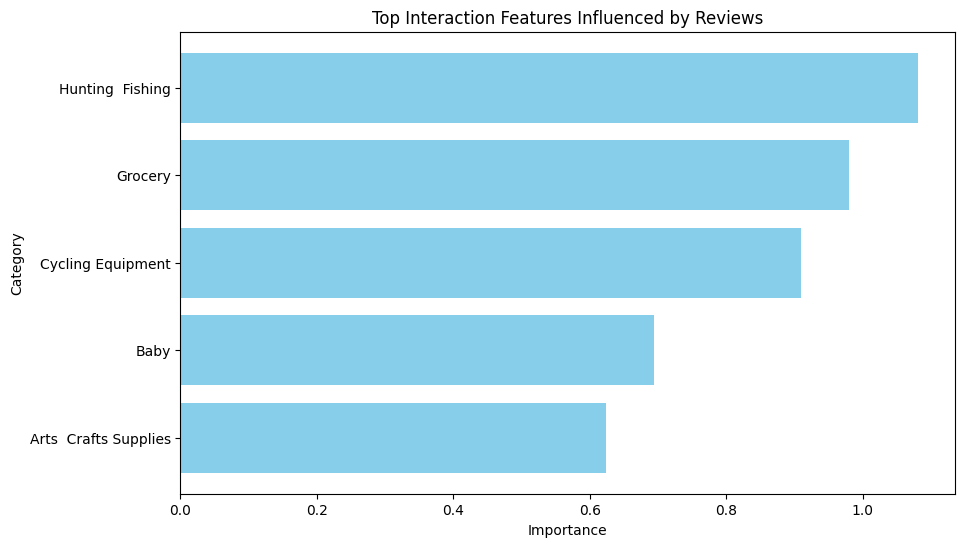

In [87]:
# Filter the DataFrame to include only the top interaction features
top_interaction_features = feature_importance_df[feature_importance_df['Feature'].str.contains('reviews_interaction')].sort_values('Importance', ascending=False).head()

# Extract just the category name from the 'Feature' column and remove the "categoryName_" prefix
top_interaction_features['Category'] = top_interaction_features['Feature'].str.split('_reviews_interaction').str[0].str.replace('categoryName_', '')

# Plot the top interaction features
plt.figure(figsize=(10, 6))
plt.barh(top_interaction_features['Category'], top_interaction_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Category')
plt.title('Top Interaction Features Influenced by Reviews')
plt.gca().invert_yaxis()
plt.show()

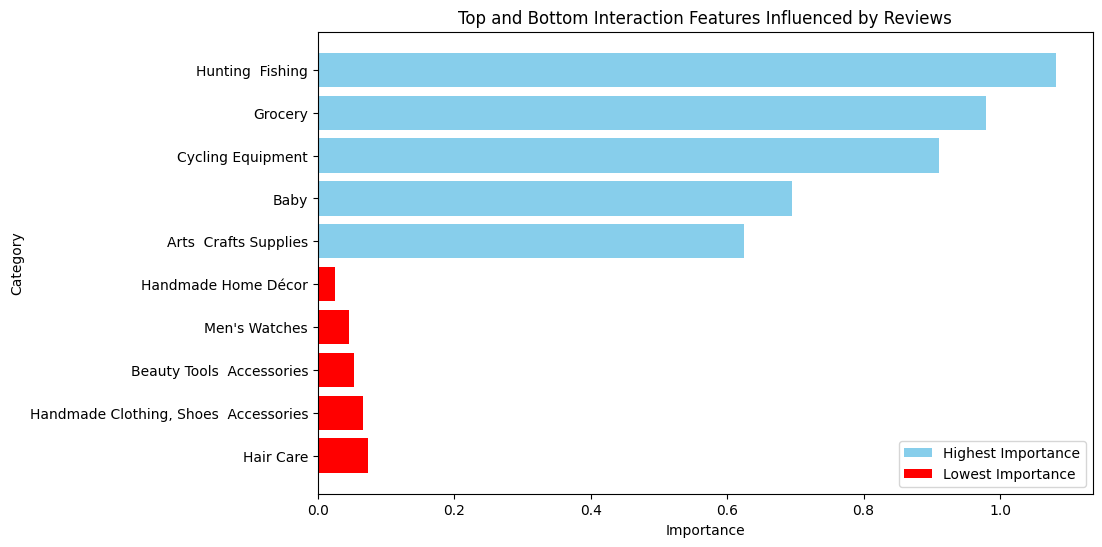

In [88]:
# Filter the DataFrame to include only the top interaction features
top_interaction_features = feature_importance_df[feature_importance_df['Feature'].str.contains('reviews_interaction')].sort_values('Importance', ascending=False).head()

# Filter the DataFrame to include only the bottom interaction features
bottom_interaction_features = feature_importance_df[feature_importance_df['Feature'].str.contains('reviews_interaction')].sort_values('Importance').head()

# Extract just the category name from the 'Feature' column and remove the "categoryName_" prefix
top_interaction_features['Category'] = top_interaction_features['Feature'].str.split('_reviews_interaction').str[0].str.replace('categoryName_', '')
bottom_interaction_features['Category'] = bottom_interaction_features['Feature'].str.split('_reviews_interaction').str[0].str.replace('categoryName_', '')

# Plot the top interaction features
plt.figure(figsize=(10, 6))
plt.barh(top_interaction_features['Category'], top_interaction_features['Importance'], color='skyblue', label='Highest Importance')
plt.barh(bottom_interaction_features['Category'], abs(bottom_interaction_features['Importance']), color='red', label='Lowest Importance')
plt.xlabel('Importance')
plt.ylabel('Category')
plt.title('Top and Bottom Interaction Features Influenced by Reviews')
plt.gca().invert_yaxis()
plt.legend()
plt.show()